In [82]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [83]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [84]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [85]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [86]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/8b/1r7k6hy13dsd_wfwtqyfg77c0000gn/T/ipykernel_7464/4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [87]:
# View all of the classes that automap found
classes = Base.classes
for cls_name in classes.keys():
    print(cls_name)

measurement
station


In [88]:
# Save references to each table
measurements = Base.classes.measurement
stations = Base.classes.station

In [89]:
# Create our session (link) from Python to the DB
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
session = Session(engine)

# Exploratory Precipitation Analysis

In [90]:
# Find the most recent date in the data set.
import datetime as dt
most_recent_date = session.query(func.max(measurements.date)).scalar()
print(most_recent_date)

2017-08-23


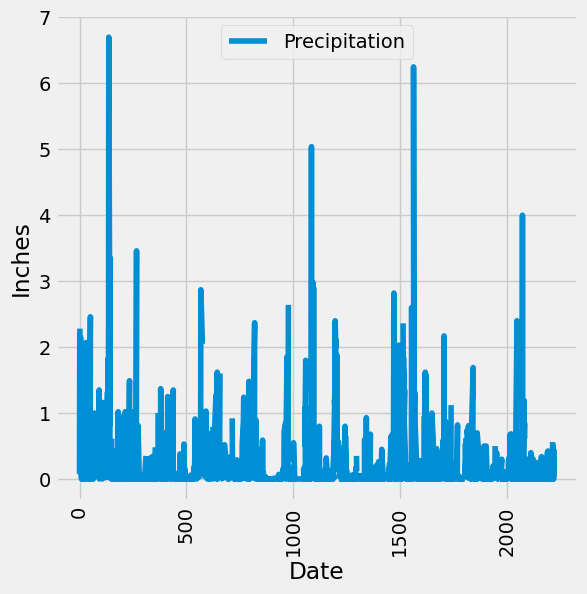

In [91]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurements.date, measurements.prcp).filter(measurements.date >= one_year_ago).order_by(measurements.date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results,columns=['date', 'prcp'])

# Sort the dataframe by date
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(y='prcp', figsize=(6, 6), legend=False)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=90)
plt.legend(["Precipitation"], loc="upper center")
plt.show()


In [92]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['prcp'].describe()
print(summary_statistics)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [93]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(stations.station)).scalar()
print(f'Total number of stations: {total_stations}')


Total number of stations: 9


In [94]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = func.count(measurements.station).label('station_count')
active_stations = session.query(stations.station, stations.name, func.count(measurements.station)).\
    filter(stations.station == measurements.station).\
    group_by(measurements.station).\
    order_by(func.count(measurements.station).desc()).all()

for station, name, count in active_stations:
    print(f'Station: {station}, Name: {name}, Count: {count}')


Station: USC00519281, Name: WAIHEE 837.5, HI US, Count: 2772
Station: USC00519397, Name: WAIKIKI 717.2, HI US, Count: 2724
Station: USC00513117, Name: KANEOHE 838.1, HI US, Count: 2709
Station: USC00519523, Name: WAIMANALO EXPERIMENTAL FARM, HI US, Count: 2669
Station: USC00516128, Name: MANOA LYON ARBO 785.2, HI US, Count: 2612
Station: USC00514830, Name: KUALOA RANCH HEADQUARTERS 886.9, HI US, Count: 2202
Station: USC00511918, Name: HONOLULU OBSERVATORY 702.2, HI US, Count: 1979
Station: USC00517948, Name: PEARL CITY, HI US, Count: 1372
Station: USC00518838, Name: UPPER WAHIAWA 874.3, HI US, Count: 511


In [96]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = active_stations[0][0]

temperature_stats = session.query(func.min(measurements.tobs), func.max(measurements.tobs), func.avg(measurements.tobs)).\
    filter(measurements.station == most_active_station_id).all()

lowest_temp = temperature_stats[0][0]
highest_temp = temperature_stats[0][1]
average_temp = temperature_stats[0][2]

lowest_temp_formatted = "{:.2f}".format(lowest_temp)
highest_temp_formatted = "{:.2f}".format(highest_temp)
average_temp_formatted = "{:.2f}".format(average_temp)

print(f"Lowest Temp: {lowest_temp_formatted} °F")
print(f"Highest Temp: {highest_temp_formatted} °F")
print(f"Average Temp: {average_temp_formatted} °F")

Lowest Temp: 54.00 °F
Highest Temp: 85.00 °F
Average Temp: 71.66 °F


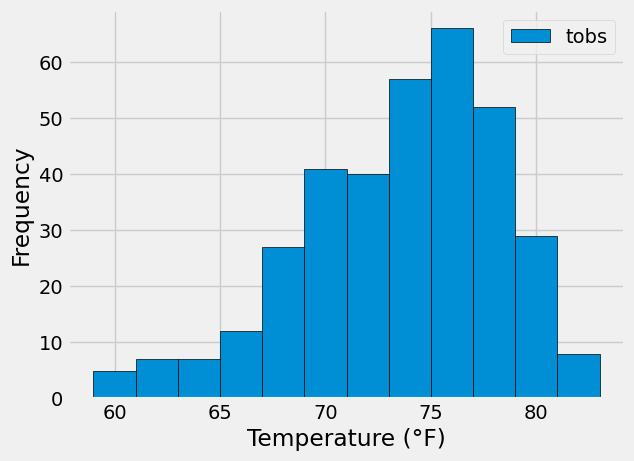

In [97]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(measurements.tobs).filter(measurements.station == most_active_station_id).filter(measurements.date >= one_year_ago).all()

temperatures = [result[0] for result in temperature_data]

plt.hist(temperatures, bins=12, edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.show()


# Close Session

In [98]:
# Close Session
session.close()